In [429]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import matplotlib.pyplot as plt
import glob 
import os

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import scale, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import recall_score, accuracy_score, precision_score, precision_recall_curve, f1_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier

player_df = pd.read_json("data/1980-2018-per100-labeled.json")

In [232]:
y_features = "MVP"
x_features = ["Player","Year","MP","FG","FGA","3P","3PA","2P","2PA","FT","FTA","ORB","DRB","AST","STL","BLK","TOV","PF","PTS"]
x_all = player_df[x_features]
y_all = player_df[y_features]
# Drop the columns containing text data, leaving only numerical data
x_all_num = x_all.drop(columns=["Player","Year"])

In [311]:
x_old = x_all.loc[x_all.Year < 2018]
y_old = y_all.loc[x_all.Year < 2018]
x_new = x_all.loc[x_all.Year == 2018]
y_new = y_all.loc[x_all.Year == 2018]
x_train, x_test, y_train, y_test = train_test_split(x_old, y_old, test_size=0.2)

In [326]:
x_train_num = x_train.drop(columns=["Player","Year"])
x_test_num = x_test.drop(columns=["Player","Year"])
x_new_num = x_new.drop(columns=["Player","Year"])

In [398]:
scale_pipe = lambda x: Pipeline([("scaler", StandardScaler()), x])
calibrate = lambda x: CalibratedClassifierCV(x, method='isotonic')

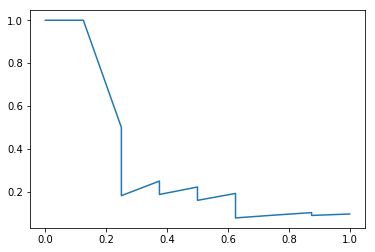

In [399]:
tree_base_clf = DecisionTreeClassifier(max_depth=2)
ada_calib = calibrate(AdaBoostClassifier(tree_base_clf, n_estimators=100, learning_rate=0.1))
ada_clf = scale_pipe(("ada", ada_calib))
ada_clf.fit(x_train_num, y_train)
precf,recf,thrf = precision_recall_curve(y_test, ada_clf.predict_proba(x_test_num).transpose()[1], pos_label=1)
plt.plot(recf, precf)

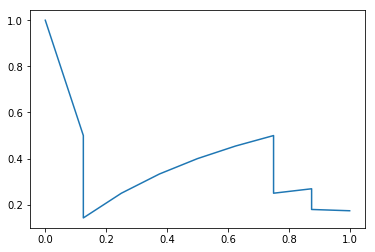

In [403]:
xgb_calib = calibrate(XGBClassifier(learning_rate = 0.1, n_jobs=2, n_estimators=100))
xgb_clf = scale_pipe(("xgb", xgb_calib))
xgb_clf.fit(x_train_num, y_train)
precf_gb, recf_gb, thrf_gb = precision_recall_curve(y_test, xgb_clf.predict_proba(x_test_num).transpose()[1], pos_label=1)
plt.plot(recf_gb, precf_gb)

In [346]:
xgb_pred_prob = xgb_clf.predict_proba(x_new_num).transpose()[1]
ada_pred_prob = ada_clf.predict_proba(x_new_num).transpose()[1]
xgb_pred_indices = np.where(xgb_pred_prob > 0.1)
ada_pred_indices = np.where(ada_pred_prob > 0.15)
print(xgb_pred_indices)
print(ada_pred_indices)

(array([143, 177]),)
(array([ 11,  85,  87,  94, 103, 105, 109, 141, 143, 170, 177, 270, 355]),)


In [333]:
xgb_clf.predict_proba(x_new_num).transpose()[1][xgb_pred_indices]

array([0.20874907, 0.12690267], dtype=float32)

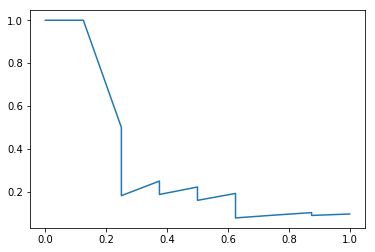

In [407]:
rf_calib = calibrate(RandomForestClassifier(n_jobs=2))
rf_clf = scale_pipe(("forest", rf_calib))
rf_clf.fit(x_train_num, y_train)
rf_pred_prob = rf_clf.predict_proba(x_new_num).transpose()[1]
precf_rf,recf_rf,thrf_rf = precision_recall_curve(y_test, rf_clf.predict_proba(x_test_num).transpose()[1], pos_label=1)
plt.plot(recf, precf)

In [408]:
stacked_prob = np.mean([xgb_pred_prob, ada_pred_prob, rf_pred_prob], axis=0)
stacked_indices = np.where(stacked_prob > 0.1)
stacked_prob[stacked_indices]

array([0.10104667, 0.1069598 , 0.1785034 , 0.16840569, 0.13288497])

In [409]:
mvp_candiates = x_new.iloc[stacked_indices]

,Player,Year,MP,FG,FGA,3P,3PA,2P,2PA,FT,FTA,ORB,DRB,AST,STL,BLK,TOV,PF,PTS
8338,Stephen Curry,2018,1605,12.5,25.3,6.2,14.7,6.2,10.6,8.1,8.9,1.0,6.5,9.2,2.4,0.2,4.5,3.4,39.4
8347,DeMar DeRozan,2018,2353,11.9,25.9,1.7,5.2,10.3,20.7,8.6,10.4,1.1,4.7,7.4,1.7,0.4,3.3,2.6,34.2
8396,James Harden,2018,2134,12.6,28.0,5.4,14.3,7.2,13.6,12.0,13.8,0.8,6.3,12.0,2.6,1.0,6.0,3.4,42.6
8430,LeBron James,2018,2518,13.7,25.1,2.4,6.5,11.3,18.7,5.9,8.2,1.5,9.8,11.8,2.0,1.3,5.6,2.2,35.7
8608,Russell Westbrook,2018,2496,13.0,29.1,1.6,5.7,11.4,23.4,7.0,9.5,2.5,10.8,14.0,2.5,0.3,6.5,3.3,34.6


Picking an arbitrary probability threshold for which players get shown in my predictions. I don't really understand why the predicted probabilities are so low.

In [430]:
x_new['Probability'] = stacked_prob
mvp_candidates = x_new.loc[x_new.Probability > 0.10]
mvp_candidates.to_json("data/mvp-predict-2018-beta.json")